STAT 453: Deep Learning (Spring 2021)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

---

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.21.0

torch: 1.9.0a0+d819a21



# LeNet-5 on MNIST

## Imports

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# From local helper files

import sys
sys.path.insert(0, '../')

from helper_evaluation import set_all_seeds, set_deterministic
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples
from helper_dataset import get_dataloaders_mnist

## Settings and Dataset

In [4]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 123
BATCH_SIZE = 256
NUM_EPOCHS = 5
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
set_all_seeds(RANDOM_SEED)
set_deterministic()

In [6]:
##########################
### MNIST DATASET
##########################

resize_transform = torchvision.transforms.Compose(
    [torchvision.transforms.Resize((32, 32)),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5,), (0.5,))])


train_loader, valid_loader, test_loader = get_dataloaders_mnist(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=resize_transform,
    test_transforms=resize_transform)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([256, 1, 32, 32])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([4, 5, 8, 9, 9, 4, 9, 9, 3, 9])


## Model

In [7]:
class LeNet5(torch.nn.Module):

    def __init__(self, num_classes, grayscale=False):
        super().__init__()
        
        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        self.features = torch.nn.Sequential(
            
            torch.nn.Conv2d(in_channels, 6, kernel_size=5),
            torch.nn.Tanh(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Conv2d(6, 16, kernel_size=5),
            torch.nn.Tanh(),
            torch.nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(16*5*5, 120),
            torch.nn.Tanh(),
            torch.nn.Linear(120, 84),
            torch.nn.Tanh(),
            torch.nn.Linear(84, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

Epoch: 001/005 | Batch 0000/0210 | Loss: 2.3033
Epoch: 001/005 | Batch 0100/0210 | Loss: 0.2083
Epoch: 001/005 | Batch 0200/0210 | Loss: 0.0928
Epoch: 001/005 | Train: 97.68% | Validation: 97.95%
Time elapsed: 0.21 min
Epoch: 002/005 | Batch 0000/0210 | Loss: 0.0640
Epoch: 002/005 | Batch 0100/0210 | Loss: 0.0742
Epoch: 002/005 | Batch 0200/0210 | Loss: 0.0539
Epoch: 002/005 | Train: 98.73% | Validation: 98.53%
Time elapsed: 0.42 min
Epoch: 003/005 | Batch 0000/0210 | Loss: 0.0624
Epoch: 003/005 | Batch 0100/0210 | Loss: 0.0878
Epoch: 003/005 | Batch 0200/0210 | Loss: 0.0137
Epoch: 003/005 | Train: 99.07% | Validation: 98.57%
Time elapsed: 0.63 min
Epoch: 004/005 | Batch 0000/0210 | Loss: 0.0186
Epoch: 004/005 | Batch 0100/0210 | Loss: 0.0574
Epoch: 004/005 | Batch 0200/0210 | Loss: 0.0083
Epoch: 004/005 | Train: 99.38% | Validation: 98.77%
Time elapsed: 0.84 min
Epoch: 005/005 | Batch 0000/0210 | Loss: 0.0404
Epoch: 005/005 | Batch 0100/0210 | Loss: 0.0134
Epoch: 005/005 | Batch 0200/

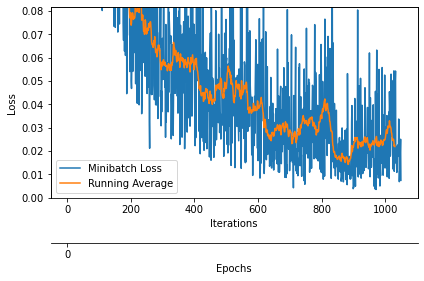

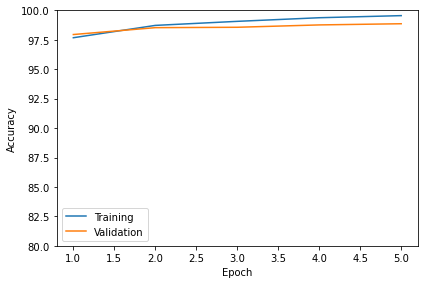

In [8]:
model = LeNet5(grayscale=True,
               num_classes=10)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([80, 100])
plt.show()

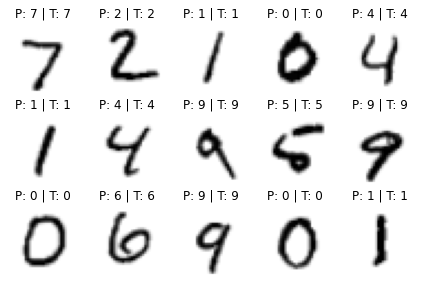

In [9]:
show_examples(model=model, data_loader=test_loader)

In [10]:
torch.save(model.state_dict(), 'saved_data/model.pt')
torch.save(optimizer.state_dict(), 'saved_data/optimizer.pt')
torch.save(scheduler.state_dict(), 'saved_data/scheduler.pt')